# ML Final Project


### Name #1, Shruti Kotha, Mia Tey, and Shruti Patel

In [4]:
#add imports
import pandas as pd
import matplotlib.pyplot as plt

## Final Project Objective: 
We can use the features (age, breed, color, animal, sex upon outcome, outcome subtype,
name) to predict outcome (Foster, Adoption, Transfer, Euthanize)

### Part 1. Data Preperation for Modeling

For this part of the assignment we read in our data and will perform various data prep techniques like data cleaning and feature engineering to prepare our data for modeling.

In [5]:
data = pd.read_csv('animaloutcomes.csv', skipinitialspace = True)
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


#### Data Cleaning

First, our label column will be "Outcome Type", since that is what we want to predict. 
If there are any records that lack an entry for "Outcome Type" we drop them.

In [80]:
print("Length before drop: ", len(data['Outcome Type']))
data = data.dropna(subset=['Outcome Type'])
print("Length after drop: ", len(data['Outcome Type']))

Length before drop:  156406
Length after drop:  156376


It looks like there are no missing values for 'Outcome Type'... Great!


Looking at the names column, there are a lot of blank entries for names. For the purposes of testing, we are
going to test with both dropping the names column and keeping it. 
First, let's see how many blank entries there are.
Second, create a temporary dataset that drops records with N/A for name. Later, we will see if accuracy is better or worse with the version that drops null name entries.

In [81]:
total_null =  data["Name"].isnull().sum()
print("Total missing values in 'Name' col before drop: ", total_null)
print("Ratio of total records with N/A for 'Name': ", total_null/len(data["Name"]), "\n")

# Create a temporary dataset that drops records with N/A for name
temp_drop_data = data.dropna(subset=['Name'])
# Verify we dropped the null records
total_null =  temp_drop_data["Name"].isnull().sum()
print("Total missing values in 'Name' col after drop: ", total_null)

Total missing values in 'Name' col before drop:  44971
Ratio of total records with N/A for 'Name':  0.28758249347725995 

Total missing values in 'Name' col after drop:  0


As for the colors, since we plan on using them for our models later, we should simplify the categories, as there are way too many unique categories for testing.
First, there are entries such as 'black/white' and 'white/black' let's combine these into one label.
Second, there are a lot of unique combinations of two colors. For these records whose combination of color makes up <5% of all colors, add these into one column called 'Multicolor' and jointly categorize it with the 'Tricolor' attribute.

In [82]:
# Combine categories such as 'black/white' and 'white/black'
def join_same_color(color):
    color_components = color.split('/')
    color_components.sort()
    return '/'.join(color_components)
data['Color'] = data['Color'].apply(join_same_color)



# Create Multicolor category 
color_counts = data['Color'].value_counts()
color_percent = color_counts / color_counts.sum() * 100
less_than_5_percent = color_percent[color_percent < 1].index
data['Color'] = data['Color'].apply(lambda x: 'Multicolor' if x in less_than_5_percent or x == 'Tricolor' else x)

Create new column for seasons

In [29]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'
    
data['Month'] = pd.to_datetime(data['MonthYear'], format='%b %Y').dt.month
data['Season'] = data['Month'].apply(get_season)
data = data.drop('Month', axis=1)
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Season
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,Spring
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,Summer
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray,Summer
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,Winter
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Spring


We'll be categorizing the various breeds in the dataset. https://www.trainpetdog.com/dog-breed-size-chart/

In [39]:

# only keep records that are Dogs
records_to_keep = ['Dog']
dog_data = data[data['Animal Type'].isin(records_to_keep)]

# only keep top 100 most frequent dog breeds in dataset
top_100_breeds = dog_data['Breed'].value_counts().head(100).index
breeds_data = dog_data[dog_data['Breed'].isin(top_100_breeds)]

# print(breeds_data)
print(breeds_data['Breed'].value_counts())


# large 70 + lbs avg, small, medium
# breed_to_category = {
#     'Pit Bull': 'Medium/Large Breeds',
#     'Labrador Retriever Mix': 'Medium/Large Breeds',
#     'Chihuahua Shorthair Mix': 'Small Breeds',
#     'German Shepard Mix': 'Medium/Large Breeds',
#     'Pit Bull': 'Medium/Large Breeds',
#     'Australian Cattle Dog Mix': 'Medium/Large Breeds',
#     'Chihuahua Shorthair': 'Small Breeds',
#     'Labrador Retriever': 'Medium/Large Breeds',
#     'German Shepherd': 'Medium/Large Breeds',
#     'Dachshund Mix': 'Medium/Small Breeds', 
#     'Boxer Mix': 'Medium/Large Breeds',
#     'Border Collie Mix': 'Medium/Large Breeds',
#     'Miniature Poodle Mix': 'Small Breeds',
#     'Siberian Husky Mix': 'Medium Breeds',
#     'Australian Shepherd Mix': 'Medium/Large Breeds',
#     'Catahoula Mix': 'Medium/Large Breeds',
#     'Staffordshire Mix': 'Medium/Large Breeds',
#     'Siberian Husky': 'Medium Breeds',
#     'Rat Terrier Mix': 'Small Breeds',
#     'Great Pyrenees Mix': 'Large Breeds',
#     'Yorkshire Terrier Mix': 'Small Breeds',
#     'Beagle Mix': 'Medium/Large Breeds',
#     'Miniature Schnauzer Mix': 'Medium/Small Breeds',
#     'Jack Russell Terrier Mix': 'Medium/Small Breeds',
#     'Pointer Mix': 'Large Breeds'
#     'Cairn Terrier Mix' : 'Small Breeds',
#     'American Bulldog Mix':,                      
#     'Chihuahua Longhair Mix':,                    
#     'Anatol Shepherd Mix':,                          
#     'Rottweiler Mix':,                               
#     'Australian Cattle Dog':,                        
#     'Black Mouth Cur Mix':,                        
#     'Plott Hound Mix':,                            
#     'Labrador Retriever/Pit Bull':,               
#     'Australian Kelpie Mix':,                    
#     'Shih Tzu Mix':,                              
#     'Chihuahua Shorthair/Dachshund' :.        
#     'Great Pyrenees':,                            
#     'American Pit Bull Terrier Mix':,             
#     'German Shepherd/Labrador Retriever':,         
#     'Dachshund/Chihuahua Shorthair':,              
#     'Labrador Retriever/German Shepherd':,          
#     'American Staffordshire Terrier Mix':,          
#     'Rottweiler':,                                   
#     'Boxer':,                                        
#     'Shih Tzu':,                                     
#     'Pit Bull/Labrador Retriever':,                  
#     'Dachshund':,                                    
#     'Golden Retriever Mix':,                         
#     'Maltese Mix':,                                  
#     'Border Terrier Mix':,                         
#     'Miniature Pinscher Mix':,                       
#     'Yorkshire Terrier':,                        
#     'Blue Lacy Mix':,                                
#     'Doberman Pinsch Mix':,                          
#     'Miniature Poodle':,                            
#     'Chow Chow Mix':,                             
#     'American Pit Bull Terrier':,                 
#     'Cairn Terrier':,                               
#     'Border Collie':,                               
#     'Queensland Heeler Mix':,                        
#     'Doberman Pinsch':,                             
#     'Basset Hound Mix':,                             
#     'Labrador Retriever/Border Collie':,           
#     'Alaskan Husky Mix':,                          
#     'Pug Mix':,                                   
#     'Beagle':,                                      
#     'Pomeranian Mix':,                              
#     'Mastiff Mix':,                                
#     'Cocker Spaniel Mix':,                          
#     'Cardigan Welsh Corgi Mix':,                    
#     'Miniature Schnauzer':,                         
#     'Lhasa Apso Mix':,                               
#     'Chinese Sharpei Mix':,                         
#     'Australian Shepherd':,                         
#     'Labrador Retriever/Australian Cattle Dog':,    
#     'Black/Tan Hound Mix':,                         
#     'Pug':,                                         
#     'Chihuahua Longhair':,                          
#     'Great Dane Mix':,                              
#     'Boston Terrier Mix':,                           
#     'Border Collie/Labrador Retriever':,            
#     'Labrador Retriever/Great Pyrenees' :,           
#     'Dachshund Wirehair Mix' :,                       
#     'Dachshund Longhair Mix' :,                    
#     'Alaskan Husky' :,                                
#     'Flat Coat Retriever Mix' :,                      
#     'Manchester Terrier Mix' :,                  
#     'Toy Poodle Mix' :,                      
#     'American Bulldog' :,             
#     'Rat Terrier' :,                  
#     'Collie Smooth Mix' :,     
#     'Maltese' :,             
#     'Anatol Shepherd' :,                 
#     'Staffordshire' :,                   
#     'Belgian Malinois Mix' :,             
#     'Pit Bull/Boxer' :,              
#     'Norfolk Terrier Mix' :,             
#     'Australian Cattle Dog/Labrador Retriever' :,
#     'Rhod Ridgeback Mix' : .                     
    
# }

# breed_unique = dog_data['Breed'].value_counts().head(100)
# pd.set_option('display.max_rows', None)

# print("breeds", breed_unique)
# pd.reset_option('display.max_rows')


Breed
Pit Bull Mix                                9623
Labrador Retriever Mix                      8132
Chihuahua Shorthair Mix                     6759
German Shepherd Mix                         3752
Pit Bull                                    2736
                                            ... 
Belgian Malinois Mix                         119
Pit Bull/Boxer                               117
Norfolk Terrier Mix                          117
Australian Cattle Dog/Labrador Retriever     116
Rhod Ridgeback Mix                           114
Name: count, Length: 100, dtype: int64


#### Graphing Data Distributions
(note: insert y'alls data cleaning stuff above this or wherever)

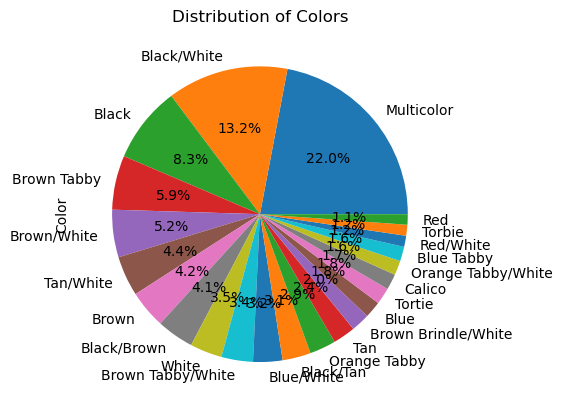

In [83]:
color_counts = data['Color'].value_counts()
color_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Colors')
plt.show()

Display of distribution of season and outcome

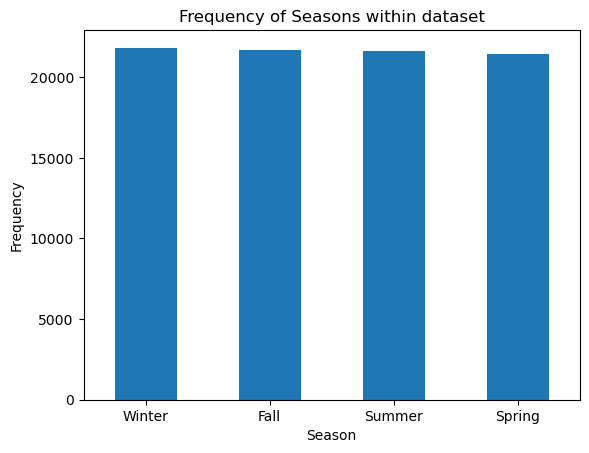

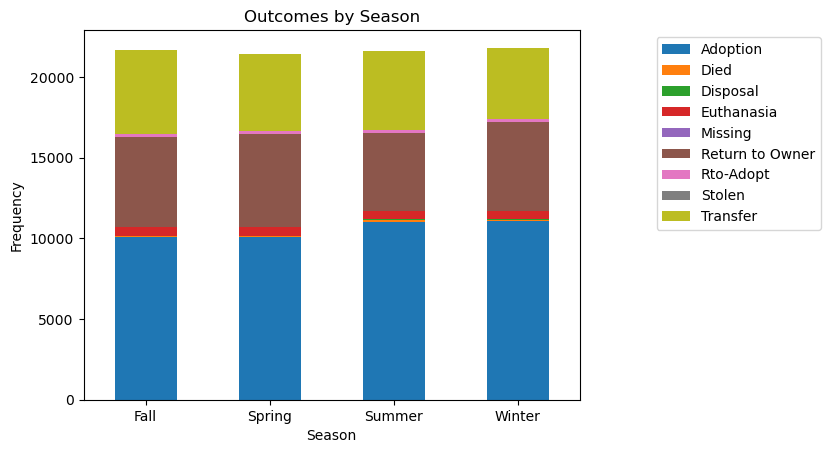

In [40]:
season_counts = dog_data['Season'].value_counts()
season_counts.plot(kind='bar')
plt.title('Frequency of Seasons within dataset')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.show()

outcome_by_season = pd.crosstab(dog_data['Season'], dog_data['Outcome Type'])
outcome_by_season.plot(kind='bar', stacked=True)
plt.title('Outcomes by Season')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

plt.show()
